Creating dot plot visualization...


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


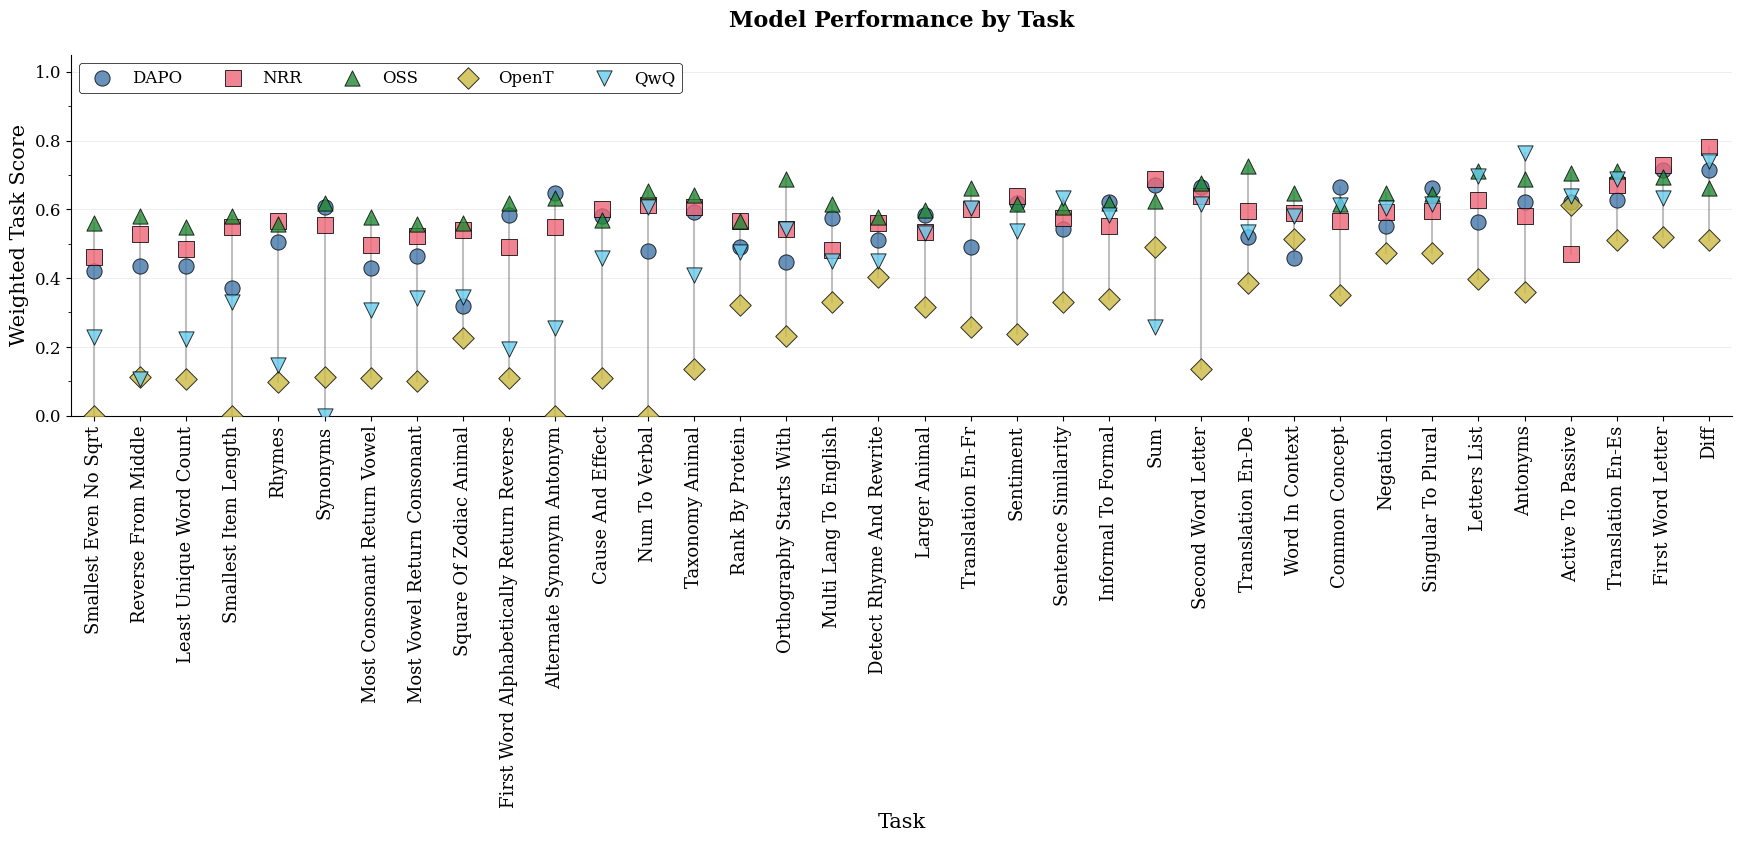


Files saved:
  PDF: task_visualizations/model_task_performance.pdf
  EPS: task_visualizations/model_task_performance.eps
  PNG: task_visualizations/model_task_performance.png

Dataset: 180 scores from 5 models across 36 tasks

Model Rankings (by mean score):
1. OSS: 0.627
2. NRR: 0.576
3. DAPO: 0.550
4. QwQ: 0.465
5. OpenT: 0.270


In [84]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Academic LaTeX-friendly matplotlib styling with larger fonts
plt.rcParams.update({
    'font.size': 14,          # Increased base font size
    'font.family': 'serif',
    'axes.titlesize': 16,     # Larger title
    'axes.labelsize': 15,     # Larger axis labels
    'xtick.labelsize': 12,    # Larger x-tick labels
    'ytick.labelsize': 12,    # Larger y-tick labels
    'legend.fontsize': 12,    # Larger legend
    'axes.linewidth': 0.8,
    'grid.linewidth': 0.5,
    'grid.alpha': 0.3,
    'text.usetex': False  # Set to True if LaTeX is installed
})

MODEL_LABELS = {
    "nvidia_Nemotron-Research-Reasoning-Qwen-1.5B": "NRR",
    "open-thoughts_OpenThinker-7B": "OpenT", 
    "openai_gpt-oss-20b": "OSS",
    "Qwen_QwQ-32B": "QwQ",
    "BytedTsinghua-SIA_DAPO-Qwen-32B": "DAPO"
}

def collect_scores(model_labels):
    """Collect weighted task scores from model prediction folders."""
    scores = []
    
    for model_name, model_label in model_labels.items():
        folder_path = f"predictions_{model_name}"
        
        if not os.path.exists(folder_path):
            continue
            
        for filename in os.listdir(folder_path):
            if filename.endswith("_with_scores.json"):
                task_name = filename.replace("_with_scores.json", "")
                
                try:
                    with open(os.path.join(folder_path, filename), "r") as f:
                        data = json.load(f)
                        score = data.get("weighted_task_score")
                        
                        if score is not None:
                            scores.append({
                                "Model": model_label,
                                "Task": task_name, 
                                "Score": score
                            })
                except Exception as e:
                    print(f"Error reading {filename}: {e}")
    
    return pd.DataFrame(scores)

def create_dot_plot_visualization(df, output_dir="task_visualizations"):
    """Create colorblind-friendly dot plot with tasks on x-axis."""
    os.makedirs(output_dir, exist_ok=True)
    
    # Prepare data: sort tasks from hardest to easiest (left to right)
    pivot_df = df.pivot(index='Task', columns='Model', values='Score')
    task_means = pivot_df.mean(axis=1).sort_values(ascending=True)
    pivot_df = pivot_df.reindex(task_means.index)
    
    # Setup figure with even more height to accommodate vertical labels
    fig, ax = plt.subplots(figsize=(18, 9))  # Even wider and taller
    
    # Colorblind-friendly palette (Tol's bright scheme)
    colors = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE']
    markers = ['o', 's', '^', 'D', 'v']  # Different markers for additional distinction
    
    models = pivot_df.columns
    x_positions = range(len(pivot_df))
    
    # Plot vertical range lines (performance spread per task)
    for i, task in enumerate(pivot_df.index):
        scores = pivot_df.loc[task].dropna().values
        if len(scores) > 1:
            ax.plot([i, i], [min(scores), max(scores)], 
                   color='gray', linewidth=1.5, alpha=0.5, zorder=1)
    
    # Plot model scores aligned on the center line (no horizontal offset)
    for j, model in enumerate(models):
        scores = pivot_df[model].values
        valid_indices = [i for i, score in enumerate(scores) if not pd.isna(score)]
        valid_x = [x_positions[i] for i in valid_indices]  # No offset - all on center line
        valid_scores = [scores[i] for i in valid_indices]
        
        ax.scatter(valid_x, valid_scores, color=colors[j % len(colors)], 
                  marker=markers[j % len(markers)], s=120, alpha=0.8,
                  label=model, zorder=3, edgecolors='black', linewidth=0.7)
    
    # Formatting
    ax.set_ylim(0, 1.05)
    ax.set_xlim(-0.5, len(pivot_df) - 0.5)
    ax.set_ylabel('Weighted Task Score')
    ax.set_xlabel('Task')
    ax.set_title('Model Performance by Task', fontweight='bold', pad=20)
    
    # Clean task labels with vertical orientation
    task_labels = []
    for task in pivot_df.index:
        clean_task = task.replace('_', ' ').title()
        # Less wrapping needed since text is vertical
        task_labels.append(clean_task)
    
    ax.set_xticks(x_positions)
    ax.set_xticklabels(task_labels, rotation=90, ha='center', fontsize=13)  # Much larger task labels
    
    # Legend in one line
    legend = ax.legend(loc='upper left', frameon=True, framealpha=1.0, 
                      edgecolor='black', ncol=len(models))  # All models in one row
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_linewidth(0.5)
    
    ax.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)
    
    # Clean academic styling
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.8)
    ax.spines['bottom'].set_linewidth(0.8)
    
    # Y-axis ticks
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticks([0.1, 0.3, 0.5, 0.7, 0.9], minor=True)
    
    plt.tight_layout(pad=2.0)  # More padding around everything
    
    # Save in LaTeX-friendly formats
    base_path = os.path.join(output_dir, "model_task_performance")
    formats = {'pdf': 'pdf', 'eps': 'eps', 'png': 'png'}
    saved_files = {}
    
    for ext, fmt in formats.items():
        path = f"{base_path}.{ext}"
        plt.savefig(path, format=fmt, dpi=300, bbox_inches='tight', 
                   facecolor='white', edgecolor='none')
        saved_files[ext] = path
    
    plt.show()
    return saved_files

def print_summary(df):
    """Print concise summary statistics."""
    print(f"\nDataset: {len(df)} scores from {df['Model'].nunique()} models across {df['Task'].nunique()} tasks")
    
    print("\nModel Rankings (by mean score):")
    model_means = df.groupby("Model")["Score"].mean().sort_values(ascending=False)
    for i, (model, score) in enumerate(model_means.items(), 1):
        print(f"{i}. {model}: {score:.3f}")

def main():
    """Main execution function."""
    print("Collecting model scores...")
    df = collect_scores(MODEL_LABELS)
    
    if df.empty:
        print("No data found. Check that prediction folders exist.")
        return
    
    print("Creating dot plot visualization...")
    files = create_dot_plot_visualization(df)
    
    print("\nFiles saved:")
    for ext, path in files.items():
        print(f"  {ext.upper()}: {path}")
    
    print_summary(df)

if __name__ == "__main__":
    main()